<a href="https://colab.research.google.com/github/SergeyKamenshchikov/Sksummy/blob/master/tree_like.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from bs4 import BeautifulSoup
import requests

from textblob import TextBlob
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 

import collections
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import re

from tabulate import tabulate

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
def tags(x):
    return nltk.pos_tag(nltk.word_tokenize(x))[0][1]

def get_unique_text(document):
    unique_sentences = []
    for sentence in [sent.raw for sent in TextBlob(document).sentences]:
        if sentence not in unique_sentences:
            unique_sentences.append(sentence)
    return ' '.join(unique_sentences)

def text_normalize(txt):
    processed_text = (re.sub('[^a-zA-Z]', ' ', txt)).lower()
    processed_text=re.sub("(\\d|\\W)+"," ",processed_text)

    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(processed_text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    tokens = [i for i in tokens if (tags(i) in ['NN', 'NNP', 'NNS', 'NNPS'])]
    return(tokens) #RETURN TOKENS

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)    

def create_graph(tokens, nodes=25, max_component=False, common=500): #INPUT TOKENS INSTEAD OF TEXT
    ## create graph
    bigrams=list(nltk.ngrams(tokens, 2))
   
    bigram_counts = collections.Counter(bigrams)
    bigram_df = pd.DataFrame(bigram_counts.most_common(common), columns=['bigram', 'count'])
    
    d = bigram_df.set_index('bigram').T.to_dict('records')
    G = nx.Graph()
    for k, v in d[0].items():
            G.add_edge(k[0], k[1]) ## NOT SETTING WEIGHT
    ## /create graph

    ## show max connected component
    if max_component==True:
        G = max(connected_component_subgraphs(G), key=len)
        G = nx.dfs_tree(G)
    ## /show max connected component

    ## remove isolates
    G.remove_nodes_from(list(nx.isolates(G)))
    ## /remove isolates

    ## filter graph by degree
    threshold = int(G.number_of_nodes()*(max(nx.degree_centrality(G).values()))) #max centrality, nodes

    for i in range(0, threshold):
        F = nx.Graph() # empty graph
        fedges = filter(lambda x: G.degree()[x[0]] > 0 and G.degree()[x[1]] > i, G.edges())
        F.add_edges_from(fedges)
        F.remove_nodes_from(list(nx.isolates(F)))

        if F.number_of_nodes() < nodes:
            break
    ## /filter graph by degree

    pos = nx.spring_layout(F, iterations=500)
    # pos = nx.nx_agraph.graphviz_layout(F)

    return F, pos

In [18]:
htmlString = requests.get('https://medium.com/@sergeykamenshchikov/nlp-for-composition-of-value-tree-d8495534ebd5')
soup = BeautifulSoup(htmlString.content, 'html.parser')
paragraphs = soup.find_all(['p', 'article', 'section', 'title', 'h1', 'h2', 'h3'])
rawtext = get_unique_text(' '.join([i.text for i in paragraphs]))

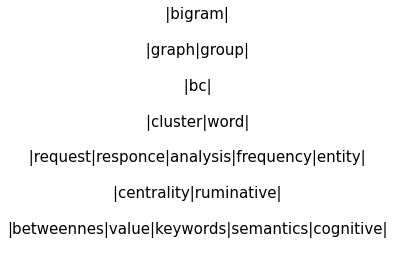

In [19]:
F,pos = create_graph(text_normalize(rawtext))
d = dict(F.degree)

#GRAPH TO TREE BLOCK
valency_list=[d.get(element) for element in d] #list of valency values
unique_v_list=list(set(valency_list)) #unique valency values
pos_y={} #list of positions from top to bottom depending on valency
i=0
for v in unique_v_list: #add step for each valency level
    pos_y[v]=i
    i=i+1

pos_x={} #list of positions from center
for v in unique_v_list:
    pos_x[v]=[element for element in (valency_list.count(v)/2-np.arange(valency_list.count(v)))]

valency_pos={}
for node in F.nodes: #add x and y for each node
    v=d[node]
    valency_pos[node]=(pos_x[v].pop(),pos_y[v])
    
levels=[]
unique_v_list.reverse()
for v in unique_v_list:
    level=[]
    for k in d:
        if d[k]==v:
            level.append(k)
    levels.append(level)


lines=[]
for level in levels:
    line='|'
    for w in level:
        line=line+w+'|'
    lines.append(line)

max_line=max([len(line) for line in lines])
pos_lines=[]
for line in lines:
    steps_to_center=(max_line-len(line))//2
    while steps_to_center>0:
        line=' '+line+' '
        steps_to_center=steps_to_center-1
    pos_lines.append(line)
    
outline=''
for line in pos_lines:
    outline=outline+line+'\n'+'\n'
    
fig = plt.figure(figsize=(max_line/10,len(pos_y)/2))
plt.text(0.5, 0.5, outline, horizontalalignment='center', verticalalignment='center', fontsize=15)
plt.axis('off')
plt.show()